# __WSI - ćwiczenie 2.__

### __Algorytmy ewolucyjne i genetyczne__


#### __Treść ćwiczenia__

- Celem ćwiczenia jest implementacja algorytmu ewolucyjnego z selekcją ruletkową, krzyżowaniem
jednopunktowym, mutacją gaussowską oraz sukcesją generacyjną. Następnie należy wykorzystać
implementacje do znalezienia rozwiazania dajacego minimalny koszt dla problemu opisanego w sekcji
- Nalezy znalezc zestaw hiperparametrów, który daje stosunkowo dobry wynik, a nastepnie
zbadac wpływ wybranego hiperparametru.

#### __Opis problemu__


Znalezc optymalną lokalizację dla fabryki, jeżeli korzysta ona z 4 zasobów. Zakładamy przy tym,
że:
- lokalizacja fabryki określona jest przez jej współrzedne $(x_1, x_2) \in R^2$,
- dzienne zapotrzebowanie fabryki to:
  1. $20$ jednostek zasobu $z_1$ transportowanego ze współrzednych $(1, 1)$,
  2. $10$ jednostek zasobu $z_2$ transportowanego ze współrzednych $(-0.5, 1)$,
  3. $5$ jednostek zasobu $z_3$ transportowanego ze współrzednych $(-1, -0.5)$,
  4. $10$ jednostek zasobu $z_4$ transportowanego ze współrzednych $(1, -1)$,
- koszt transportu jednostki każdego z zasobów wyliczany to $1−e^{−d_M}$, gdzie $d_M$ - to odległość
Manhattan od lokalizacji fabryki,
- celem optymalizacji jest znalezienie lokalizacji fabryki, która minimalizuje sumaryczny dzienny
koszt dostarczania zasobów do fabryki.

In [135]:
import numpy as np
from plotly import graph_objs as go
from plotly.express.colors import sample_colorscale
from plotly.subplots import make_subplots
import pandas as pd
import math
import os
from IPython.display import Image

if not os.path.exists("images"):
    os.mkdir("images")

RNG = np.random.default_rng()

#### __Definicja funkcji straty__

In [136]:
def manhattan(p1, p2):
    return sum([abs(p1[i] - p2[i]) for i in range(len(p1))])

def trans_cost(p1, p2):
    return 1 - math.exp(-manhattan(p1, p2))

def loss(pos):
    return (20 * trans_cost([1, 1], pos) +
            10 * trans_cost([-0.5, 1], pos) +
            5 * trans_cost([-1, -0.5], pos) +
            10 * trans_cost([1, -1], pos))

#### __Algorytm ewolucyjny__

__Selekcja ruletkowa:__ 
- Funkcja prawdopodobieństwa wyboru osobnika $i$: $p_i = \frac{g_i} {\sum\limits_{j=1}^{N}g_j}$
- Dla problemu minimalizacji zamieniam funkcję straty w funkcję zysku $g(x) = f_{max} - f(x)$
- Najgorszy osobnik ma zerowe szanse przetrwania

In [137]:
def get_prob(population):
    min_grades = [loss(x) for x in population]
    max_grade = max(min_grades)
    min_to_max = [max_grade - f for f in min_grades]
    sum_grades = sum(min_to_max)
    return [g/sum_grades for g in min_to_max]

def select_roulette(population, probability_list, output_size):
    return RNG.choice(population, output_size, replace=True, p=probability_list).tolist()

__Krzyowanie jednopunktowe:__

__UWAGA__ Krzyżowanie dla osobnika posiadającego tylko 2 geny może się odbyć tylko w punkcie środkowym. Implementacja jest jednak uniwersalna.

In [138]:
def one_point_cross(vect):
    split = RNG.integers(1, len(vect[0]))
    return [vect[0][:split] + vect[1][split:], 
            vect[1][:split] + vect[0][split:]]

__Mutacja Gaussowska:__

In [139]:
def mutate_gauss(individual, sigma):
    return [x + RNG.normal(0, sigma) for x in individual]

__Sukcesja generacyjna:__
- Zaimplementowana wyłącznie w celu ewentualnej zamiany na inną metodę sukcesji
- Zwraca odpowiedneigo rozmiaru populację 

In [140]:
def replace(x, size):
    return x[:size]

__Algorytm ewolucyjny:__

In [141]:
def evo(loss_func, start_pop, num_iters, mutation_strength, cross_probability):
    """
    Implementation of evolutionary algorithm for minimalisation purposes
    with roulette selection, gaussian mutation, one point crossover and
    generational succesion. Usable with n-dimensional problems, if a suitable
    loss function is provided.

    Args:
        loss_func: a function that given a array of genes returns its loss value
        start_pop: 2D array of individuals consisting of genes, which will make the first generation
        num_iters: number of iterations (generations)
        mutation_strength: the variance of gaussian distribution, from which a mutation will be drawn
        cross_probability: probability of crossover for a given crossover loop iteration

    Returns:
        Returns a tuple consisting of:
        [0]: A 3D numpy array of generations, in which there are individuals (arrays of genes)
        [1]: The best (one that has the smallest loss function value) individual (list of genes) 

    Raises:
        None
    """

    # initialize parameters
    population = start_pop
    pop_size = len(population)
    iterations = [population]

    # get first best individual
    best_p = min(population, key=lambda k: loss_func(k))
    
    # algorithm loop
    i = 0
    while i < num_iters:
        next_pop = []
        # create a list of probabilities which will determine 
        # how likely an individual is to be drawn to be a parent
        probability_list = get_prob(population)
        # selection and crossover
        while len(next_pop) < pop_size:
            # determine if in this iteration crossover will take place
            mutate = RNG.choice([True, False], 1, replace=True, 
                                p=[cross_probability, 1 - cross_probability])
            # if yes, select 2 individuals, cross them and add them
            # to the new generation
            if mutate:  
                next_pop += one_point_cross(select_roulette(population, probability_list, 2))
            # else select 1 individual and add him to the new generation
            else:
                next_pop += select_roulette(population, probability_list, 1)
        # mutate the whole population and replace the old one
        population = replace([mutate_gauss(x, mutation_strength) for x in next_pop], pop_size)
        # add the population to the output array
        iterations.append(population)
        # get new best individual, if such exists in the current generation
        new_best_p = min(population, key=lambda k: loss_func(k))
        if loss_func(new_best_p) < loss_func(best_p):
            best_p = new_best_p
        i += 1
    
    return np.array(iterations), best_p

#### __Analiza działania i wydajności algorytmu__

__Przykład wywołania__

In [142]:
data = evo(loss, [RNG.uniform(-1, 1, 2) for _ in range(30)], 50, 0.01, 0.5)
generations = data[0]
result = data[1]
print(result)

[0.9982560157081771, 1.0000862603675602]


__Graficzna reprezentacja ewolucji__

In [143]:
X, Y = generations[:,:,0].flatten(), generations[:,:,1].flatten()

layout = go.Layout(width=700, height=500,
                    title='Factory location',
                    xaxis_title='x',
                    yaxis_title='y',
                    plot_bgcolor='DarkSeaGreen')
fig = go.Figure(layout=layout)

colorscale = sample_colorscale('Agsunset', list(np.linspace(0, 1, len(generations))))
colorscale.reverse()
colorscale[-1]='white'
for i, pop in enumerate(generations):
    fig.add_trace(go.Scatter(x=pop[:,0], y=pop[:,1], mode='markers',
                  name=f'population {i}', 
                  marker=dict(size=6,
                  color=colorscale[i])))
fig.add_trace(go.Scatter(x=[result[0]], y=[result[1]], mode='markers',
                  name=f'best', 
                  marker=dict(size=6,
                  color='black')))
fig.show()

__Doświadczenia statystyczne__

Poniższy kod pozwala na zbadanie wybranego parametru w zadanym obszarze. Efekty doświadczenia znajdują się w tabelach oraz wykresach poniżej.

In [144]:
ITERATION_NUMBER = 50
POPULATION_SIZE = 30
MUTATION_STRENGTH = 0.01
CROSSOVER_PROBABILITY = 0.5

# np.geomspace(0.0001, 0.5, 10)
test = np.arange(0.001, 0.005, 0.001)
test = [np.round(t, 3) for t in test]
param_name = 'crossover probability'
runs_amount = 50

data = [([evo(loss, [RNG.uniform(-1, 1, 2) for _ in range(POPULATION_SIZE)], ITERATION_NUMBER, MUTATION_STRENGTH, param)  for _ in range(runs_amount)], param) for param in test]

col_names = ['x', 'y', 'loss', 'x err (abs)', 'y err (abs)', 'x stddev', 'y stddev']
df_columns = []
df_data = [[]]*runs_amount
for param_data, param in data:
    df_data = np.append(df_data, [[x[1][0], x[1][1], loss(x[1]), abs(x[1][0] - 1), abs(x[1][1] - 1), np.std(x[0][-1][:][0]), np.std(x[0][-1][:][1])] for x in param_data], axis=1)
    df_columns += [(param, name) for name in col_names]

df = pd.DataFrame(columns=df_columns, data=df_data)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df


KeyboardInterrupt: 

In [ ]:
df.describe()

0.001                                                           \
               x          y       loss x err (abs) y err (abs)   x stddev   
count  50.000000  50.000000  50.000000   50.000000   50.000000  50.000000   
mean    0.774832   0.981617  23.133809    0.226456    0.019091   0.129539   
std     0.513995   0.050703   2.992670    0.513417    0.050435   0.251062   
min    -0.500248   0.781959  21.270726    0.000007    0.000007   0.000567   
25%     0.982063   0.997177  21.285181    0.000481    0.000324   0.006356   
50%     0.999678   0.999633  21.327157    0.000989    0.000696   0.015712   
75%     1.000531   1.000279  23.784938    0.018010    0.003246   0.070876   
max     1.009838   1.006698  30.401917    1.500248    0.218041   0.767722   

                      0.002                        ...       0.008             \
        y stddev          x          y       loss  ... y err (abs)   x stddev   
count  50.000000  50.000000  50.000000  50.000000  ...   50.000000  50.000000   
mean    0.130405   0.910034   0.985341  22.442455  ...    0.008601   0.045098   
std     0.251831   0.291294   0.053234   2.241048  ...    0.030147   0.114377   
min     0.000186  -0.499287   0.732354  21.270020  ...    0.000007   0.000156   
25%     0.007002   0.997385   0.998906  21.281518  ...    0.000284   0.005766   
50%     0.016537   0.999607   0.999927  21.295175  ...    0.000720   0.014143   
75%     0.082477   1.000097   1.000238  22.182401  ...    0.002314   0.025149   
max     0.761769   1.002378   1.015460  30.167550  ...    0.162751   0.747713   

                      0.009                                                \
        y stddev          x          y       loss x err (abs) y err (abs)   
count  50.000000  50.000000  50.000000  50.000000   50.000000   50.000000   
mean    0.044597   0.882907   0.976105  22.637099    0.117472    0.024215   
std     0.116469   0.360301   0.080409   2.576045    0.360175    0.080311   
min     0.000051  -0.500291   0.532080  21.266909    0.000022    0.000006   
25%     0.005697   0.997558   0.999119  21.276203    0.000159    0.000142   
50%     0.011719   0.999728   0.999861  21.296148    0.000572    0.000339   
75%     0.023561   1.000086   1.000138  22.488053    0.002442    0.001349   
max     0.757036   1.002017   1.001375  29.944838    1.500291    0.467920   

                             
        x stddev   y stddev  
count  50.000000  50.000000  
mean    0.077342   0.077840  
std     0.177697   0.178470  
min     0.000170   0.000312  
25%     0.004794   0.004290  
50%     0.009490   0.011530  
75%     0.048659   0.045843  
max     0.765616   0.743895  

[8 rows x 63 columns]

- Średnia sum błędów (mean sum of errors): $ME = \frac{\sum\limits_{i=1}^{n}|x_i - x_{est}|+|y_i - y_{est}|} {2n}$ - __UWAGA__: Przekroje funkcji straty nie muszą być liniowe więc ta metryka nie musi dawać wyników współmiernych do jakości hiperparametrów! Zazwyczaj nie znamy też minimum dla danego problemu, wtedy korzyść z takiej metryki byłaby znikoma.
- Średnia sum odchyleń standardowych osobników ostatniej generacji (mean sum of deviations): $MD = \frac{\sum\limits_{i=1}^{n}x_i{dev}+y_i{dev}} {2n}$
- Średnia wartości funkcji starty w znalezionych punktach: $ML = \frac{\sum\limits_{i=1}^{n}loss(x_i+y_i)} {n}$

In [ ]:
df_stat = pd.DataFrame()
for param in df.columns.get_level_values(0).unique():
    df_stat[(param, 'ME')] = [df.loc[:, [(param, 'x err (abs)'), (param, 'y err (abs)')]].sum(axis=1).mean()/2]
    df_stat[(param, 'MD')] = [df.loc[:, [(param, 'x stddev'), (param, 'y stddev')]].sum(axis=1).mean()/2]
    df_stat[(param, 'ML')] = [df.loc[:, (param, 'loss')].mean()]
df_stat.columns = pd.MultiIndex.from_tuples(df_stat.columns)
df_stat

0.001                          0.002                          0.003  \
         ME        MD         ML        ME        MD         ML        ME   
0  0.122774  0.129972  23.133809  0.053393  0.057576  22.442455  0.087582   

                           0.004  ...      0.006     0.007           \
         MD         ML        ME  ...         ML        ME       MD   
0  0.096174  22.836203  0.059994  ...  22.358073  0.062964  0.07249   

                 0.008                          0.009                       
          ML        ME        MD         ML        ME        MD         ML  
0  22.386945  0.036791  0.044847  22.135854  0.070844  0.077591  22.637099  

[1 rows x 27 columns]

__Kod generujący wykresy__

In [ ]:
# ITERATION_NUMBER = 50
# POPULATION_SIZE = 30
# MUTATION_STRENGTH = 0.02
# CROSSOVER_PROBABILITY = 0.5
# f'ME / MD / ML (iter = {ITERATION_NUMBER}, pop size = {POPULATION_SIZE}, mut strength = {MUTATION_STRENGTH})'
layout = go.Layout(width=1400, height=500,
                   title_text='ME / MD / ML',
                   plot_bgcolor='DarkSeaGreen')

fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Scatter(mode='lines+markers', 
                         marker=dict(size=6,
                                     color=colorscale[0]),
                         line=dict(color=colorscale[0], width=3), 
                         x=df_stat.columns.get_level_values(0).unique(),
                         y=df_stat.loc[0, [x for x in df_stat.columns if x[1]=='ME']].tolist(),
                         name='ME'),
                         row=1, col=1)
fig.add_trace(go.Scatter(mode='lines+markers', 
                         marker=dict(size=6,
                                     color=colorscale[-2]),
                         line=dict(color=colorscale[-2], width=3), 
                         x=df_stat.columns.get_level_values(0).unique(),
                         y=df_stat.loc[0, [x for x in df_stat.columns if x[1]=='MD']].tolist(),
                         name='MD'),
                         row=1, col=2)
fig.add_trace(go.Scatter(mode='lines+markers', 
                         marker=dict(size=6,
                                     color='Darkslategrey'),
                         line=dict(color='Darkslategrey', width=3), 
                         x=df_stat.columns.get_level_values(0).unique(),
                         y=df_stat.loc[0, [x for x in df_stat.columns if x[1]=='ML']].tolist(),
                         name='ML'),
                         row=1, col=3)
fig.update_xaxes(title_text=param_name, type='linear')
fig.update_yaxes(title_text='ME', row=1, col=1)
fig.update_yaxes(title_text='MD', row=1, col=2)
fig.update_yaxes(title_text='ML', row=1, col=3)
fig.update_layout(layout)
# fig.show()
# fig.write_image('images/crossover.png')

#### __Wnioski__

__Wpływ siły mutacji na wydajność algorytmu__

Z przeprowadzonych przeze mnie doświadczeń wynika, że siła mutacji znacząco wpływa na efektywność działania algorytmu. 

* Zwiększanie siły mutacji poprawia pokrycie badanej przestrzeni, czyli właściwości eksploracyjne. Jednak kiedy parametr jest zbyt duży, to czy znajdziemy dobre rozwiązanie jest właściwie losowe, ponieważ koncentracja osobników jest bardzo mała (środkowy wykres). Najlepsze wartości genów nie mają szansy zdominować populacji i, co za tym idzie, właściwości eksploatacji przestrzeni są słabe (prawy wykres). 
* Zmniejszanie siły mutacji zwiększa możliwości eksploatacyjne. Dobre osobniki zaczynają dominować w populacji a skupienie populacji jest dużo większe (środkowy wykres). Niestety kiedy parametr ten jest niski, algorytm potrzebuje bardzo dużej ilości iteracji, żeby wolno mutująca populacja dotarła do minimum (prawy wykres). Istenieje też szansa, że przy zbyt małej sile mutacji algorytm wpadać będzie w minima lokalne.

Najlepsza siła mutacji dla tego problemu plasuje się wobec tego mniej więcej w przedziale $[0.01, 0.1]$

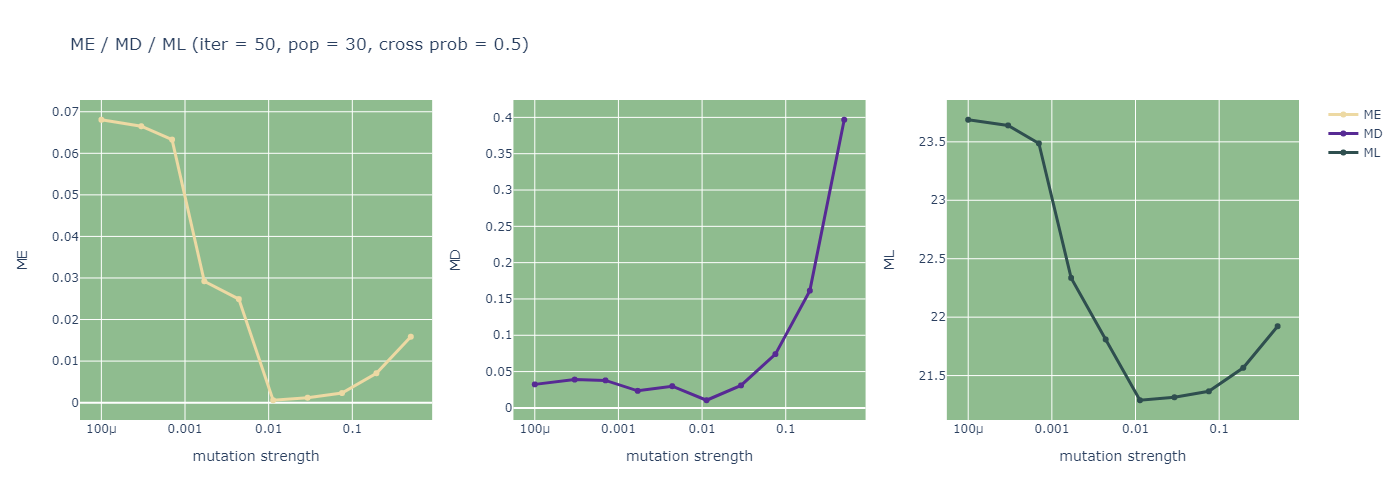

In [ ]:
Image("images/mutation.png")